# Faraday

This tutorial explains how Faraday works and how to use Faraday to train a generative model and generate synthetic smart meter data.

---

Faraday is a Conditional Variational Auto-Encoder (VAE)-based model. Unlike traditional VAEs where seeds are drawn from a normal distribution and decoded, Faraday works by:
1. First train a VAE using the following loss functions: a. MMD instead of KL-divergence b. Quantile losses and c. Mean squared error
2. Encode real samples to the latent space using the encoder, and fit a Gaussian Mixture Model (GMM) over the latent space.
3. During inference, draw samples from the GMM and decode with the decoder.

For more information on Faraday's architecture, refer to the [Faraday paper](https://arxiv.org/abs/2404.04314).


### Pre-requisites

If you haven't already, please download LCL dataset from [data.london.gov.uk](https://data.london.gov.uk/dataset/smartmeter-energy-use-data-in-london-households). 


In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os

import sys

import logging

logger = logging.getLogger(__name__)

# 💿 Loading LCL Data

In [15]:
from pathlib import Path
from opensynth.data_modules.lcl_data_module import LCLDataModule
import pytorch_lightning as pl

import matplotlib.pyplot as plt

data_path = Path("../../data/processed/historical/train/lcl_data.csv")
stats_path = Path("../../data/processed/historical/train/mean_std.csv")
outlier_path = Path("../../data/processed/historical/train/outliers.csv")

dm = LCLDataModule(data_path=data_path, stats_path=stats_path, batch_size=200, n_samples=2000)
dm.setup()

In [16]:
dm_with_outliers = LCLDataModule(data_path=data_path, stats_path=stats_path, batch_size=200, n_samples=2000, outlier_path=outlier_path)
dm_with_outliers.setup()

# 🤖 VAE Module

In [17]:
from opensynth.models.faraday.model import FaradayVAE
# Option to pass in your own encoder architecture in the future
model = FaradayVAE(class_dim=2, latent_dim=16, learning_rate=0.001, mse_weight=3)

In [18]:
# Batch size 500 is when MPS becomes faster than CPU..
# But sometimes large batch size hurts convergence..
# Suggest training on CPU with small batch size
# And potentially experiment with best hyperparameters on large batch size before using 'mps'

trainer = pl.Trainer(max_epochs=250, accelerator="auto")
trainer.fit(model, dm_with_outliers)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name           | Type                    | Params | Mode 
-------------------------------------------------------------------
0 | encoder        | Encoder                 | 201 K  | train
1 | decoder        | Decoder                 | 200 K  | train
2 | reparametriser | ReparametrisationModule | 544    | train
-------------------------------------------------------------------
402 K     Trainable params
0         Non-trainable params
402 K     Total params
1.609     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode
/Users/charlotte.avery/.virtualenvs/OpenSynth-BNsxhSIM/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the

Epoch 249: 100%|██████████| 10/10 [00:00<00:00, 32.73it/s, v_num=1, total_loss=6.560, mmd_loss=0.0771, mse_loss=4.440, quantile_loss=2.040]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 10/10 [00:00<00:00, 29.41it/s, v_num=1, total_loss=6.560, mmd_loss=0.0771, mse_loss=4.440, quantile_loss=2.040]


# 🕸️ GMM Module

In [20]:
from opensynth.models.faraday.model import FaradayModel
import numpy as np
import torch

Need to update model s.t. `feature_list` is saved if want to load model from checkpoint. For now, use trained VAE. 

In [9]:
# model = FaradayVAE.load_from_checkpoint("lightning_logs/version_0/checkpoints/epoch=249-step=25000.ckpt", map_location=torch.device('cpu'))

# faraday_model_1500 = FaradayModel(vae_module=model, n_components=1500, max_iter=100, tol=1e-2)
# faraday_model_150 = FaradayModel(vae_module=model, n_components=150, max_iter=100, tol=1e-2)
# faraday_model_50 = FaradayModel(vae_module=model, n_components=50, max_iter=100, tol=1e-2)
# faraday_model_10 = FaradayModel(vae_module=model, n_components=10, max_iter=100, tol=1e-2)
# faraday_model_1 = FaradayModel(vae_module=model, n_components=1, max_iter=100, tol=1e-2)


In [21]:
faraday_model_10 = FaradayModel(vae_module=model, n_components=10, max_iter=100, tol=1e-2)

In [22]:
gmm_data_module = LCLDataModule(data_path=data_path, stats_path=stats_path, batch_size=5000, n_samples=50000, outlier_path=outlier_path)
gmm_data_module.setup()

In [23]:
faraday_model_10.train_gmm(dm=gmm_data_module)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/charlotte.avery/.virtualenvs/OpenSynth-BNsxhSIM/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/charlotte.avery/.virtualenvs/OpenSynth-BNsxhSIM/lib/python3.11/site-packages/pytorch_lightning/core/optimizer.py:182: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name         | Type           | Params | Mode 
--------------------------------------------------------
0 | model        | KMeansModel    | 0      | train
1 | vae_module   | FaradayVAE     | 402 K  | train
2 | sampler      | UniformSampler | 0      | train
  | other params | n/a            | 1      | n/a  
--------------------------------------------------------
402 K     Trainable params
0         Non-trainable params
402 K     Total params
1.609     

Running K-Means initialisation
--------------------------------------------------------------
Epoch 0: 100%|██████████| 10/10 [00:00<00:00, 13.57it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 10/10 [00:00<00:00, 13.55it/s, v_num=0]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type               | Params | Mode 
-------------------------------------------------------------------
0 | model               | KMeansModel        | 0      | train
1 | vae_module          | FaradayVAE         | 402 K  | train
2 | centroid_aggregator | CentroidAggregator | 0      | train
3 | metric_inertia      | MeanMetric         | 0      | train
  | other params        | n/a                | 1      | n/a  
-------------------------------------------------------------------
402 K     Trainable params
0         Non-trainable params
402 K     Total params
1.609     Total estimated model params size (MB)
35        Modules in train mode
0         Modules in eval mode



Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 13.57it/s, v_num=0, inertia=21.70]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 13.52it/s, v_num=0, inertia=21.70]
Done K-Means initialisation
Beginning GMM Training


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name             | Type                 | Params | Mode 
------------------------------------------------------------------
0 | model            | GaussianMixtureModel | 0      | train
1 | vae_module       | FaradayVAE           | 402 K  | train
2 | prior_aggregator | PriorAggregator      | 0      | train
3 | covar_aggregator | CovarianceAggregator | 0      | train
  | other params     | n/a                  | 1      | n/a  
------------------------------------------------------------------
402 K     Trainable params
0         Non-trainable params
402 K     Total params
1.609     Total estimated model params size (MB)
35        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 10/10 [00:00<00:00, 12.35it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 10/10 [00:00<00:00, 12.26it/s, v_num=0]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name             | Type                 | Params | Mode 
------------------------------------------------------------------
0 | model            | GaussianMixtureModel | 0      | train
1 | vae_module       | FaradayVAE           | 402 K  | train
2 | model_copy       | GaussianMixtureModel | 0      | train
3 | prior_aggregator | PriorAggregator      | 0      | train
4 | mean_aggregator  | MeanAggregator       | 0      | train
5 | covar_aggregator | CovarianceAggregator | 0      | train
6 | metric_nll       | MeanMetric           | 0      | train
  | other params     | n/a                  | 1      | n/a  
------------------------------------------------------------------
402 K     Trainable params
0         Non-trainable params
402 K     Total params
1.609     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode



Epoch 27: 100%|██████████| 10/10 [00:00<00:00, 14.92it/s, v_num=0, nll=-6.03]
Total training time: 98.09412980079651


In [24]:
faraday_model_10.train_gmm(dm=gmm_data_module)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type           | Params | Mode 
--------------------------------------------------------
0 | model        | KMeansModel    | 0      | train
1 | vae_module   | FaradayVAE     | 402 K  | train
2 | sampler      | UniformSampler | 0      | train
  | other params | n/a            | 1      | n/a  
--------------------------------------------------------
402 K     Trainable params
0         Non-trainable params
402 K     Total params
1.609     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Running K-Means initialisation
--------------------------------------------------------------
Epoch 0: 100%|██████████| 10/10 [00:00<00:00, 13.37it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 10/10 [00:00<00:00, 13.36it/s, v_num=0]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type               | Params | Mode 
-------------------------------------------------------------------
0 | model               | KMeansModel        | 0      | train
1 | vae_module          | FaradayVAE         | 402 K  | train
2 | centroid_aggregator | CentroidAggregator | 0      | train
3 | metric_inertia      | MeanMetric         | 0      | train
  | other params        | n/a                | 1      | n/a  
-------------------------------------------------------------------
402 K     Trainable params
0         Non-trainable params
402 K     Total params
1.609     Total estimated model params size (MB)
35        Modules in train mode
0         Modules in eval mode



Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 12.44it/s, v_num=0, inertia=21.50]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 12.40it/s, v_num=0, inertia=21.50]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name             | Type                 | Params | Mode 
------------------------------------------------------------------
0 | model            | GaussianMixtureModel | 0      | train
1 | vae_module       | FaradayVAE           | 402 K  | train
2 | prior_aggregator | PriorAggregator      | 0      | train
3 | covar_aggregator | CovarianceAggregator | 0      | train
  | other params     | n/a                  | 1      | n/a  
------------------------------------------------------------------
402 K     Trainable params
0         Non-trainable params
402 K     Total params
1.609     Total estimated model params size (MB)
35        Modules in train mode
0         Modules in eval mode



Done K-Means initialisation
Beginning GMM Training
Epoch 0: 100%|██████████| 10/10 [00:00<00:00, 14.59it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 10/10 [00:00<00:00, 14.56it/s, v_num=0]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name             | Type                 | Params | Mode 
------------------------------------------------------------------
0 | model            | GaussianMixtureModel | 0      | train
1 | vae_module       | FaradayVAE           | 402 K  | train
2 | model_copy       | GaussianMixtureModel | 0      | train
3 | prior_aggregator | PriorAggregator      | 0      | train
4 | mean_aggregator  | MeanAggregator       | 0      | train
5 | covar_aggregator | CovarianceAggregator | 0      | train
6 | metric_nll       | MeanMetric           | 0      | train
  | other params     | n/a                  | 1      | n/a  
------------------------------------------------------------------
402 K     Trainable params
0         Non-trainable params
402 K     Total params
1.609     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode



Epoch 23: 100%|██████████| 10/10 [00:00<00:00, 14.65it/s, v_num=0, nll=-5.89]
Total training time: 90.72292900085449


In [44]:
# torch.save(faraday_model_1500, "faraday_model_1500.pt")
# torch.save(faraday_model_150, "faraday_model_150.pt")
# torch.save(faraday_model_50, "faraday_model_50.pt")
# torch.save(faraday_model_10, "faraday_model_10.pt")
# torch.save(faraday_model_1, "faraday_model_1.pt")

# 📈 Comparing Results

### 0. Generating Samples

In [27]:
def generate_synthetic_samples(model, n_samples, dm):
    gmm_samples = model.sample_gmm(model, n_samples)
    gmm_samples_reconstructed = dm.reconstruct_kwh(gmm_samples['kwh'])
    gmm_samples_reconstructed = torch.clip(gmm_samples_reconstructed, min=0)
    return gmm_samples_reconstructed

In [28]:
# gmm_1500 = generate_synthetic_samples(faraday_model_1500, 20000, dm)
# gmm_150 = generate_synthetic_samples(faraday_model_150, 20000, dm)
# gmm_50 = generate_synthetic_samples(faraday_model_50, 20000, dm)
gmm_10 = generate_synthetic_samples(faraday_model_10, n_samples=20000, dm=dm)
# gmm_1 = generate_synthetic_samples(faraday_model_1, 20000, dm)

In [29]:
real_kwh = dm.reconstruct_kwh(next(iter(gmm_data_module.train_dataloader()))['kwh'])
real_kwh = torch.clip(real_kwh, min=0) # Clip min 0 to get read of negative values

### 1. Comparing mean, 95th quantile, median profiles

In [30]:
def plot_stats(real_kwh, gmm_reconstruct):

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 3), sharey=True, gridspec_kw={'wspace': 0.05})

    ax1.plot(real_kwh.mean(dim=0).detach().numpy(), label="real kwh")
    ax1.plot(gmm_reconstruct.mean(dim=0).detach().numpy(), label="gmm kwh")
    ax1.set_title("Mean kWh per half hour")
    ax1.set_xlabel("Settlement Periods")
    ax1.legend()

    ax2.plot(real_kwh.quantile(0.95, dim=0).detach().numpy(), label="real kwh")
    ax2.plot(gmm_reconstruct.quantile(0.95, dim=0).detach().numpy(), label="gmm kwh")
    ax2.set_title("95th Quantile kWh per half hour")
    ax2.set_xlabel("Settlement Periods")
    ax2.legend()

    ax3.plot(real_kwh.quantile(0.5, dim=0).detach().numpy(), label="real kwh")
    ax3.set_title("Median kWh per half hour")
    ax3.set_xlabel("Settlement Periods")
    ax3.plot(gmm_reconstruct.quantile(0.5, dim=0).detach().numpy(), label="gmm kwh")
    ax3.legend()

    fig.text(0.1, 0.5, 'kWh', va='center', rotation='vertical')

In [ ]:
# plot_stats(real_kwh, gmm_1500)

In [34]:
# plot_stats(real_kwh, gmm_150)

In [35]:
# plot_stats(real_kwh, gmm_50)

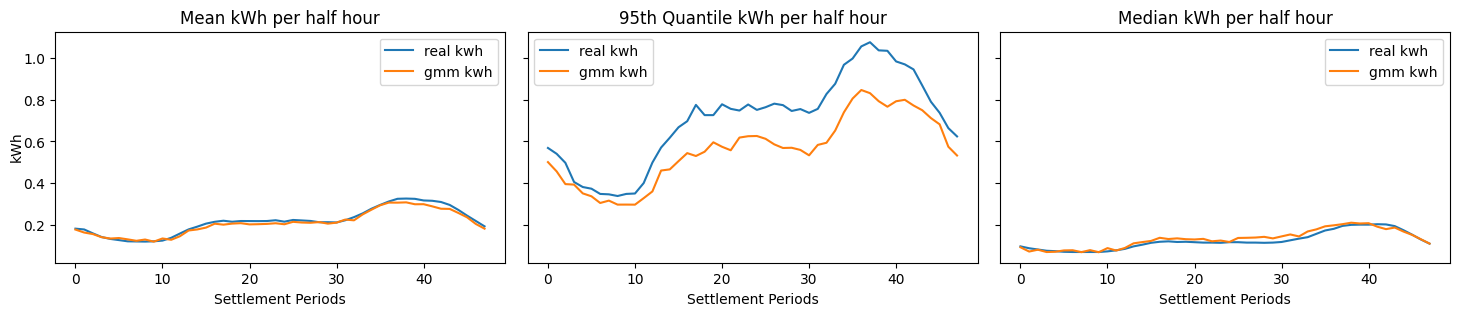

In [36]:
plot_stats(real_kwh, gmm_10)

In [37]:
# plot_stats(real_kwh, gmm_1)

### 2. PCA and TSNE Distribution Plots

In [38]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np


def train_pca_and_tsne(real_kwh, gmm_reconstruct):
    pca = PCA(n_components=2)
    tsne = TSNE(n_components=2)

    pca.fit(real_kwh.detach().numpy())
    pca_real = pca.transform(real_kwh.detach().numpy())
    pca_gmm = pca.transform(gmm_reconstruct.detach().numpy())

    tsne_input = np.concatenate([real_kwh.detach().numpy(), gmm_reconstruct.detach().numpy()])
    tsne_results = tsne.fit_transform(tsne_input)
    tsne_real = tsne_results[:len(real_kwh)]
    tsne_gmm = tsne_results[len(real_kwh):]

    return pca_real, pca_gmm, tsne_real, tsne_gmm


def plot_pca_tsne(pca_real, pca_gmm, tsne_real, tsne_gmm):
    fig, (ax_pca, ax_tsne) = plt.subplots(1, 2, figsize=(12, 4))

    ax_pca.scatter(pca_real[:, 0], pca_real[:, 1], label="real kwh", s=0.3, alpha=0.5)
    ax_pca.scatter(pca_gmm[:, 0], pca_gmm[:, 1], label="gmm kwh", s=0.3, alpha=0.5)
    ax_pca.set_title("PCA")
    ax_pca.set_xlabel("PCA 1")
    ax_pca.set_ylabel("PCA 2")
    ax_pca.legend()

    ax_tsne.scatter(tsne_real[:, 0], tsne_real[:, 1], label="real kwh", s=0.3, alpha=0.5)
    ax_tsne.scatter(tsne_gmm[:, 0], tsne_gmm[:, 1], label="gmm kwh", s=0.3, alpha=0.5)
    ax_tsne.set_title("TSNE")
    ax_tsne.set_xlabel("TSNE 1")
    ax_tsne.set_ylabel("TSNE 2")
    ax_tsne.legend()
    return fig


In [39]:
# a1, a2, a3, a4 = train_pca_and_tsne(real_kwh, gmm_1500)
# _ = plot_pca_tsne(a1, a2, a3, a4)
# plt.title("GMM with 1500 clusters")

In [40]:
# b1, b2, b3, b4 = train_pca_and_tsne(real_kwh, gmm_150)
# _ = plot_pca_tsne(b1, b2, b3, b4)
# plt.title("GMM with 150 clusters")

In [41]:
# c1, c2, c3, c4 = train_pca_and_tsne(real_kwh, gmm_50)
# _ = plot_pca_tsne(c1, c2, c3, c4)
# plt.title("GMM with 50 clusters")

Text(0.5, 1.0, 'GMM with 10 clusters')

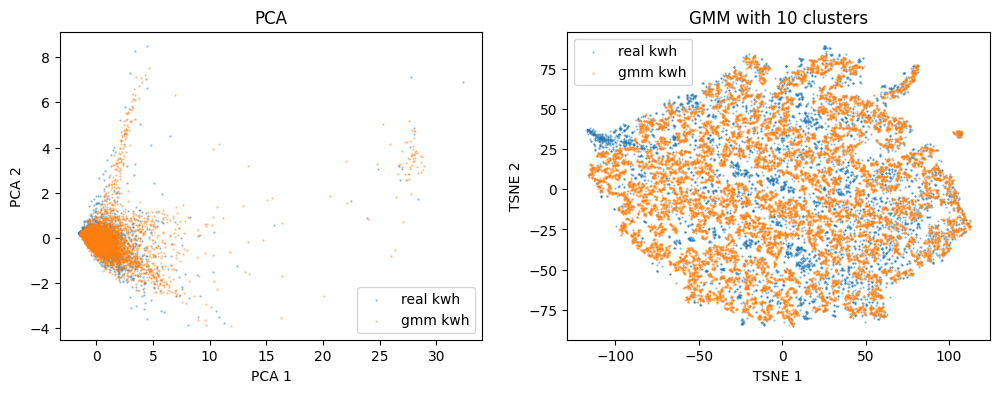

In [42]:
d1, d2, d3, d4 = train_pca_and_tsne(real_kwh, gmm_10)
_ = plot_pca_tsne(d1, d2, d3, d4)
plt.title("GMM with 10 clusters")

In [43]:
# e1, e2, e3, e4 = train_pca_and_tsne(real_kwh, gmm_1)
# _ = plot_pca_tsne(e1, e2, e3, e4)
# plt.title("GMM with 10 clusters")

# 🛃 Customising your VAE Architecture

It's possible to also customise your VAE archicture without touching the rest of Faraday code. You can do this by:

1. Creating a custom class inheriting from the Encoder and Decoder module
2. Using `super().__init__()` to inherit all the attributes and methods of the parent class
3. Overriding the attribute `encoder_layers` or `decoder_layers`. 

In this example, we'll be showing how to do this with simple linear layers, but in reality you could use more complicated architectures such as Conv1D layers, or LSTM layers.
For more complex layers, you'll need to make sure that you've shaped the inputs correctly.

In [45]:
from opensynth.models.faraday.model import FaradayVAE, Encoder, Decoder, FaradayModel
import torch.nn as nn
import torch

### Create Custom Encoder and Decoder Architectures.

In [46]:
class CustomEncoderModule(Encoder):
    """
    Custom Encoder Module
    """
    def __init__(self, latent_dim: int, input_dim: int, class_dim: int):
        """
        Inherit parent encoder attributes and methods.
        But we will be overriding the `encoder_layers` attribute
        with our custom encoder architecture.

        When inheriting from parent `Encoder` class, we need to
        pass in the attributes: latent_dim, input_dim, class_dim.

        Outputs of encoder_layers should be `latent_dim`.

        Args:
            latent_dim (int): Latent dimension.
            input_dim (int): Input dimensions.
            class_dim (int): Class dimensions.
        """
        super().__init__(latent_dim=latent_dim, input_dim=input_dim, class_dim=class_dim)
        self.encoder_layers = nn.Sequential(
            nn.Linear(self.encoder_input_dim, 1024),
            nn.GELU(),
            nn.Linear(1024, self.latent_dim)
        )


class CustomDecoderModule(Decoder):
    """
    Custom Decoder Module
    """
    def __init__(self, class_dim: int, latent_dim: int, output_dim: int):
        """
        Inherit parent decoder attributes and methods.
        But we will be overriding the `decoder_layers` attribute
        with our custom decoder architecture.

        When inheriting from parent `Decoder` class, we need to
        pass in the attributes: class_dim, latent_dim, output_dim.

        Outputs of encoder_layers should be `output_dim`.

        Args:
            latent_dim (int): Latent dimension.
            output_dim (int): Output dimensions.
            class_dim (int): Class dimensions.
        """
        super().__init__(class_dim=class_dim, latent_dim=latent_dim, output_dim=output_dim)
        self.decoder_layers = nn.Sequential(
            nn.Linear(self.latent_dim, 1024),
            nn.GELU(),
            nn.Linear(1024, self.output_dim)
        )

### Initiate Faraday VAE with custom encoder and decoders

In [47]:
custom_encoder = CustomEncoderModule(class_dim=2, latent_dim=16, input_dim=48)
custom_decoder = CustomDecoderModule(class_dim=2, latent_dim=16, output_dim=48)

faraday_custom_vae = FaradayVAE(
    class_dim=2, 
    latent_dim=16, 
    learning_rate=0.001, 
    mse_weight=3, 
    custom_encoder=custom_encoder, 
    custom_decoder=custom_decoder
)

custom_trainer = pl.Trainer(max_epochs=250, accelerator="cpu")
custom_trainer.fit(faraday_custom_vae, dm)


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/charlotte.avery/.virtualenvs/OpenSynth-BNsxhSIM/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name           | Type                    | Params | Mode 
-------------------------------------------------------------------
0 | encoder        | CustomEncoderModule     | 68.6 K | train
1 | decoder        | CustomDecoderModule     | 66.9 K | train
2 | reparametriser | ReparametrisationModule | 544    | train
-------------------------------------------------------------------
136 K     Trainable params
0         Non-trainable params
136 K     Total params
0.544     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode
/Users/charlotte.avery/.virtualenvs/OpenSynth-BNsxhSIM/lib/python3.11/site-packages/pytorch_lightnin

Epoch 249: 100%|██████████| 10/10 [00:00<00:00, 92.47it/s, v_num=2, total_loss=0.852, mmd_loss=0.0126, mse_loss=0.188, quantile_loss=0.651] 

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 10/10 [00:00<00:00, 87.74it/s, v_num=2, total_loss=0.852, mmd_loss=0.0126, mse_loss=0.188, quantile_loss=0.651]


In [49]:
faraday_custom_model = FaradayModel(vae_module=faraday_custom_vae, n_components=15, max_iter=10000, tol=1e-5)
gmm_data_module = LCLDataModule(data_path=data_path, stats_path=stats_path, batch_size=5000, n_samples=50000)
gmm_data_module.setup()
faraday_custom_model.train_gmm(dm=gmm_data_module)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/charlotte.avery/.virtualenvs/OpenSynth-BNsxhSIM/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/charlotte.avery/.virtualenvs/OpenSynth-BNsxhSIM/lib/python3.11/site-packages/pytorch_lightning/core/optimizer.py:182: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name         | Type           | Params | Mode 
--------------------------------------------------------
0 | model        | KMeansModel    | 0      | train
1 | vae_module   | FaradayVAE     | 136 K  | train
2 | sampler      | UniformSampler | 0      | train
  | other params | n/a            | 1      | n/a  
--------------------------------------------------------
136 K     Trainable params
0         Non-trainable params
136 K     Total params
0.544     

Running K-Means initialisation
--------------------------------------------------------------
Epoch 0: 100%|██████████| 10/10 [00:00<00:00, 13.79it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 10/10 [00:00<00:00, 13.77it/s, v_num=0]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type               | Params | Mode 
-------------------------------------------------------------------
0 | model               | KMeansModel        | 0      | train
1 | vae_module          | FaradayVAE         | 136 K  | train
2 | centroid_aggregator | CentroidAggregator | 0      | train
3 | metric_inertia      | MeanMetric         | 0      | train
  | other params        | n/a                | 1      | n/a  
-------------------------------------------------------------------
136 K     Trainable params
0         Non-trainable params
136 K     Total params
0.544     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode



Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 13.59it/s, v_num=0, inertia=76.40]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 13.54it/s, v_num=0, inertia=76.40]
Done K-Means initialisation
Beginning GMM Training


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name             | Type                 | Params | Mode 
------------------------------------------------------------------
0 | model            | GaussianMixtureModel | 0      | train
1 | vae_module       | FaradayVAE           | 136 K  | train
2 | prior_aggregator | PriorAggregator      | 0      | train
3 | covar_aggregator | CovarianceAggregator | 0      | train
  | other params     | n/a                  | 1      | n/a  
------------------------------------------------------------------
136 K     Trainable params
0         Non-trainable params
136 K     Total params
0.544     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 10/10 [00:00<00:00, 15.72it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 10/10 [00:00<00:00, 15.68it/s, v_num=0]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name             | Type                 | Params | Mode 
------------------------------------------------------------------
0 | model            | GaussianMixtureModel | 0      | train
1 | vae_module       | FaradayVAE           | 136 K  | train
2 | model_copy       | GaussianMixtureModel | 0      | train
3 | prior_aggregator | PriorAggregator      | 0      | train
4 | mean_aggregator  | MeanAggregator       | 0      | train
5 | covar_aggregator | CovarianceAggregator | 0      | train
6 | metric_nll       | MeanMetric           | 0      | train
  | other params     | n/a                  | 1      | n/a  
------------------------------------------------------------------
136 K     Trainable params
0         Non-trainable params
136 K     Total params
0.544     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


Epoch 37: 100%|██████████| 10/10 [00:00<00:00, 15.15it/s, v_num=0, nll=14.80]
Total training time: 98.61353993415833


### Check Results

In [54]:
custom_gmm_samples = faraday_custom_model.sample_gmm(n_samples=10000)

custom_gmm_kwh = custom_gmm_samples['kwh']
custom_gmm_reconstruct = dm.reconstruct_kwh(custom_gmm_kwh)
custom_gmm_resconstruct = torch.clip(custom_gmm_reconstruct, min=0) # Clip min 0 to get read of negative values

In [56]:
custom_real_kwh = dm.reconstruct_kwh(next(iter(gmm_data_module.train_dataloader()))['kwh'])
custom_real_kwh = torch.clip(custom_real_kwh, min=0) # Clip min 0 to get read of negative values

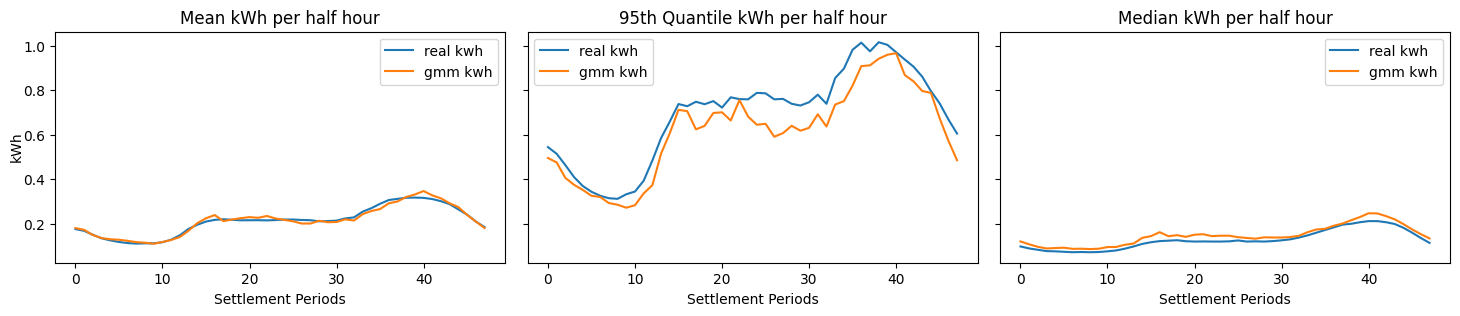

In [57]:
plot_stats(custom_real_kwh, custom_gmm_resconstruct)

In [58]:
a,b,c,d = train_pca_and_tsne(custom_real_kwh, custom_gmm_resconstruct)

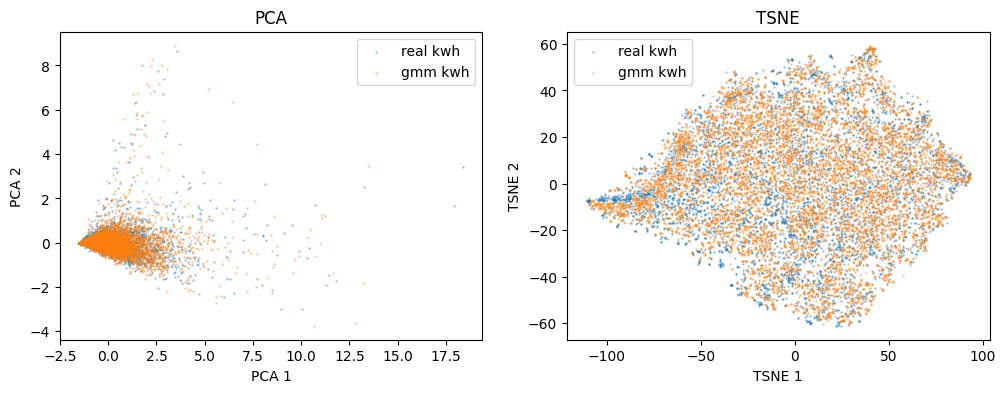

In [59]:
_ = plot_pca_tsne(a, b, c, d)

# 🔐 Training with Differential Privacy (DP-SGD)

Privacy should be one of the concerns with genarating synthetic data, especially when done for data sharing purposes. To implement privacy, we use Differentially-Private Stochastic Gradient Descent [[1]](https://arxiv.org/abs/1607.00133) implemented with Pytorch Opacus library [[2]](https://opacus.ai/).

You can train Faraday with Differential Privacy turned on with the `differential_privacy` parameter as demonstrated below. When implementing DP-SGD, you need to specify the following:

1. `epsilon` - the level of privacy (high epsilon = less private)
2. `delta` - this should be $<<1/N$, where $N$ is the size of the dataset

For more context and considerations between Privacy and synthetic smart meter generation, e.g. on deciding `epsilon` value, check out this paper from Centre for Net Zero: [Defining "Good": Evalution Framework for SYnthetic Smart Meter Data](https://arxiv.org/abs/2407.11785).

In [60]:
from opensynth.models.faraday.model import FaradayVAE

vae_dp = FaradayVAE(
    class_dim=2,
    latent_dim=16,
    learning_rate=0.001,
    mse_weight=3,
    differential_privacy=True,
    epsilon=8.0,
    delta=1/20000,
)

dp_trainer = pl.Trainer(max_epochs=25, accelerator="cpu")
dp_trainer.fit(vae_dp, dm)

/Users/charlotte.avery/.virtualenvs/OpenSynth-BNsxhSIM/lib/python3.11/site-packages/opacus/privacy_engine.py:95: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/charlotte.avery/.virtualenvs/OpenSynth-BNsxhSIM/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/charlotte.avery/.virtualenvs/OpenSynth-BNsxhSIM/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLo

Epoch 0:  10%|█         | 1/10 [00:00<00:01,  6.44it/s, v_num=3]

/Users/charlotte.avery/.virtualenvs/OpenSynth-BNsxhSIM/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 24: 100%|██████████| 10/10 [00:00<00:00, 15.98it/s, v_num=3, total_loss=6.270, mmd_loss=0.673, mse_loss=3.060, quantile_loss=2.540, epsilon=7.820]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 10/10 [00:00<00:00, 12.76it/s, v_num=3, total_loss=6.270, mmd_loss=0.673, mse_loss=3.060, quantile_loss=2.540, epsilon=7.820]
